# Test 4 solution
## Question 3

### 1.- Data cleaning and preprocessing

Fisrt of all, data preprocessing is the first (and arguably most important) step toward building a working machine learning model. It’s critical!

In [1]:
# Common imports
import pandas as pd
import numpy as np

# to make this notebook's output stable across runs
random_state=17

# importing dataset
from sklearn.datasets import load_boston

In [2]:
dataset = load_boston()
print(dataset.DESCR)

.. _boston_dataset:

Boston house prices dataset
---------------------------

**Data Set Characteristics:**  

    :Number of Instances: 506 

    :Number of Attributes: 13 numeric/categorical predictive. Median Value (attribute 14) is usually the target.

    :Attribute Information (in order):
        - CRIM     per capita crime rate by town
        - ZN       proportion of residential land zoned for lots over 25,000 sq.ft.
        - INDUS    proportion of non-retail business acres per town
        - CHAS     Charles River dummy variable (= 1 if tract bounds river; 0 otherwise)
        - NOX      nitric oxides concentration (parts per 10 million)
        - RM       average number of rooms per dwelling
        - AGE      proportion of owner-occupied units built prior to 1940
        - DIS      weighted distances to five Boston employment centres
        - RAD      index of accessibility to radial highways
        - TAX      full-value property-tax rate per $10,000
        - PTRATIO  pu

In [3]:
data = np.c_[dataset['data'], dataset['target']]
columns = list(dataset.feature_names) + ['MEDV']
df = pd.DataFrame(data=data, columns=columns)
df.sample(random_state=random_state)

,CRIM,ZN,INDUS,CHAS,NOX,RM,AGE,DIS,RAD,TAX,PTRATIO,B,LSTAT,MEDV
191,0.06911,45.0,3.44,0.0,0.437,6.739,30.8,6.4798,5.0,398.0,15.2,389.71,4.69,30.5


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 506 entries, 0 to 505
Data columns (total 14 columns):
CRIM       506 non-null float64
ZN         506 non-null float64
INDUS      506 non-null float64
CHAS       506 non-null float64
NOX        506 non-null float64
RM         506 non-null float64
AGE        506 non-null float64
DIS        506 non-null float64
RAD        506 non-null float64
TAX        506 non-null float64
PTRATIO    506 non-null float64
B          506 non-null float64
LSTAT      506 non-null float64
MEDV       506 non-null float64
dtypes: float64(14)
memory usage: 55.4 KB


In [5]:
df.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
CRIM,506.0,3.613524,8.601545,0.00632,0.082045,0.25651,3.677083,88.9762
ZN,506.0,11.363636,23.322453,0.00000,0.000000,0.00000,12.500000,100.0000
INDUS,506.0,11.136779,6.860353,0.46000,5.190000,9.69000,18.100000,27.7400
CHAS,506.0,0.069170,0.253994,0.00000,0.000000,0.00000,0.000000,1.0000
NOX,506.0,0.554695,0.115878,0.38500,0.449000,0.53800,0.624000,0.8710
RM,506.0,6.284634,0.702617,3.56100,5.885500,6.20850,6.623500,8.7800
AGE,506.0,68.574901,28.148861,2.90000,45.025000,77.50000,94.075000,100.0000
DIS,506.0,3.795043,2.105710,1.12960,2.100175,3.20745,5.188425,12.1265
RAD,506.0,9.549407,8.707259,1.00000,4.000000,5.00000,24.000000,24.0000
TAX,506.0,408.237154,168.537116,187.00000,279.000000,330.00000,666.000000,711.0000


From our DataFrame information and description there is no missing data neither any work to do before continue with the next step; however, **ZN** and **CHAS** data looks strange, so we will pay close attention to these features. Now, as we are asked to fit classification models in order to predict whether a given suburb has a crime rate above or below the median, we drop this column and add as our target in its binarized form.

In [6]:
df['CRIM01'] = df['CRIM'].apply(lambda x: 1 if x > df['CRIM'].median() else 0)
df = df.drop('CRIM', axis=1)
df.sample(random_state=random_state)

,ZN,INDUS,CHAS,NOX,RM,AGE,DIS,RAD,TAX,PTRATIO,B,LSTAT,MEDV,CRIM01
191,45.0,3.44,0.0,0.437,6.739,30.8,6.4798,5.0,398.0,15.2,389.71,4.69,30.5,0


Now we are ready to work with our dataset.

### 2.- Items (a) and (b)

In [7]:
import matplotlib.pyplot as plt

import time
import warnings
warnings.filterwarnings("ignore")

from sklearn.model_selection import KFold
from sklearn.model_selection import GridSearchCV
from sklearn.neighbors import KNeighborsClassifier

First, we look for the most correlated features with our target 


In [8]:
df.corr()['CRIM01'].abs().nlargest(10)

CRIM01    1.000000
NOX       0.723235
RAD       0.619786
DIS       0.616342
AGE       0.613940
TAX       0.608741
INDUS     0.603260
LSTAT     0.453263
ZN        0.436151
B         0.351211
Name: CRIM01, dtype: float64

Then, as **ZN** and **CHAS** are not in our ranking above, we will consider from **NOX** to **INDUS**; moreover, 
in order to drop unecessary features we look for strongly correlated ones.

In [9]:
names = df.corr()['CRIM01'].abs().nlargest(7)
prospective_predictors = list(names.index)
prospective_predictors.remove('CRIM01')
df.corr().loc[prospective_predictors][prospective_predictors].abs()

,NOX,RAD,DIS,AGE,TAX,INDUS
NOX,1.000000,0.611441,0.769230,0.731470,0.668023,0.763651
RAD,0.611441,1.000000,0.494588,0.456022,0.910228,0.595129
DIS,0.769230,0.494588,1.000000,0.747881,0.534432,0.708027
AGE,0.731470,0.456022,0.747881,1.000000,0.506456,0.644779
TAX,0.668023,0.910228,0.534432,0.506456,1.000000,0.720760
INDUS,0.763651,0.595129,0.708027,0.644779,0.720760,1.000000


According to the table above, we point out that **RAD** and **TAX** are strongly correlated. Finally, we make some boxplots in order to make a decision about our predictor subsets.

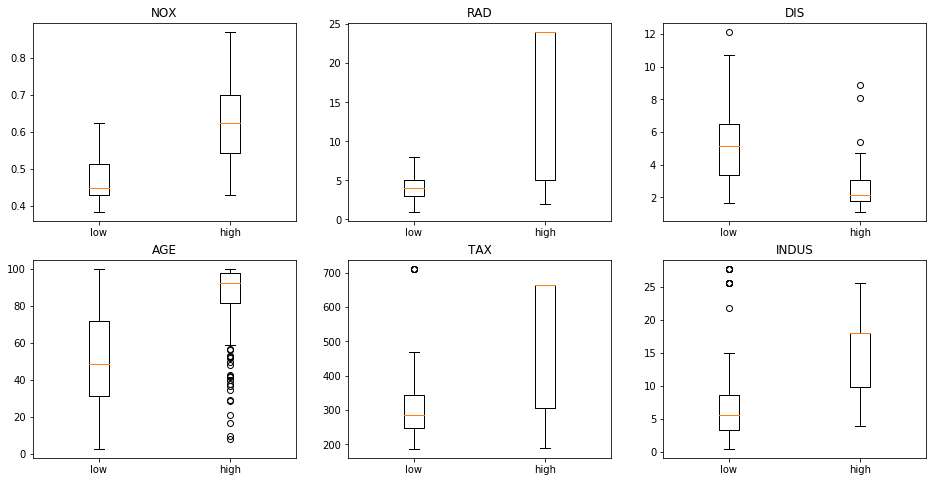

In [10]:
fig_scatter, axs = plt.subplots(2,3, figsize=(16,8))

for feature, ax in zip(prospective_predictors, axs.flatten()):
    
    high = df[df['CRIM01'] == 1][feature]
    low = df[df['CRIM01'] == 0][feature]
    ax.boxplot([low,high], labels=['low','high'])
    ax.set_title(feature)    

plt.show()

From the boxplots above, **NOX**, **RAD**, **DIS** and **INDUS** looks like potential candidates. Finally, from all the observations above, we will explore optimal valued for **K** in the three subsets bellow, as we are asked to make some plots we limit our analysis to only two predictors. 

In [11]:
subset_0 = ['NOX', 'RAD']
subset_1 = ['NOX', 'DIS']
subset_2 = ['RAD', 'DIS']
subsets = [subset_0, subset_1, subset_2]

In [12]:
cv = KFold(n_splits=10, random_state=random_state)

#---number of folds---
folds = 10

#---creating odd list of K for KNN---
ks = list(range(1,int(len(df) * ((folds - 1)/folds))))

#---remove all multiples of 2---
ks = [k for k in ks if k % 2 != 0]

param_grid = {
    'n_neighbors': ks
}

y = df.loc[:,'CRIM01']

cls = []
ks = []

for subset in subsets:
    
    X = df.loc[:,subset]
    knn_grid = GridSearchCV(KNeighborsClassifier(), param_grid=param_grid, cv=cv, n_jobs=-1, verbose=True)
    stime = time.time()
    knn_grid.fit(X, y)
    cls.append(knn_grid.best_estimator_)
    ks.append(knn_grid.best_params_['n_neighbors'])
    sec = time.time() - stime
    print("Predictors: %s and %s" % (subset[0], subset[1]))
    print("Time for knn fitting: %2d min. %2d sec." % (sec/60, sec%60))
    print("The parameter of the best classifier is %s \nIts mean test score is %0.3f\n"
          % (knn_grid.best_params_, knn_grid.best_score_))

Fitting 10 folds for each of 227 candidates, totalling 2270 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done 113 tasks      | elapsed:    4.8s
[Parallel(n_jobs=-1)]: Done 713 tasks      | elapsed:   21.9s
[Parallel(n_jobs=-1)]: Done 1713 tasks      | elapsed:   59.0s
[Parallel(n_jobs=-1)]: Done 2270 out of 2270 | elapsed:  1.4min finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.


Predictors: NOX and RAD
Time for knn fitting:  1 min. 23 sec.
The parameter of the best classifier is {'n_neighbors': 11} 
Its mean test score is 0.907

Fitting 10 folds for each of 227 candidates, totalling 2270 fits


[Parallel(n_jobs=-1)]: Done 340 tasks      | elapsed:    8.7s
[Parallel(n_jobs=-1)]: Done 1540 tasks      | elapsed:   50.2s
[Parallel(n_jobs=-1)]: Done 2270 out of 2270 | elapsed:  1.4min finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.


Predictors: NOX and DIS
Time for knn fitting:  1 min. 22 sec.
The parameter of the best classifier is {'n_neighbors': 1} 
Its mean test score is 0.791

Fitting 10 folds for each of 227 candidates, totalling 2270 fits


[Parallel(n_jobs=-1)]: Done 340 tasks      | elapsed:    8.8s
[Parallel(n_jobs=-1)]: Done 1540 tasks      | elapsed:   51.4s


Predictors: RAD and DIS
Time for knn fitting:  1 min. 22 sec.
The parameter of the best classifier is {'n_neighbors': 31} 
Its mean test score is 0.814



[Parallel(n_jobs=-1)]: Done 2270 out of 2270 | elapsed:  1.4min finished


### 3.- Item (c)

Now, we make a plot for every best classifier found in the previous section.

In [13]:
y = df.loc[:,'CRIM01']
y = y.to_numpy().astype(np.float64).ravel()
colors = ['blue', 'red']

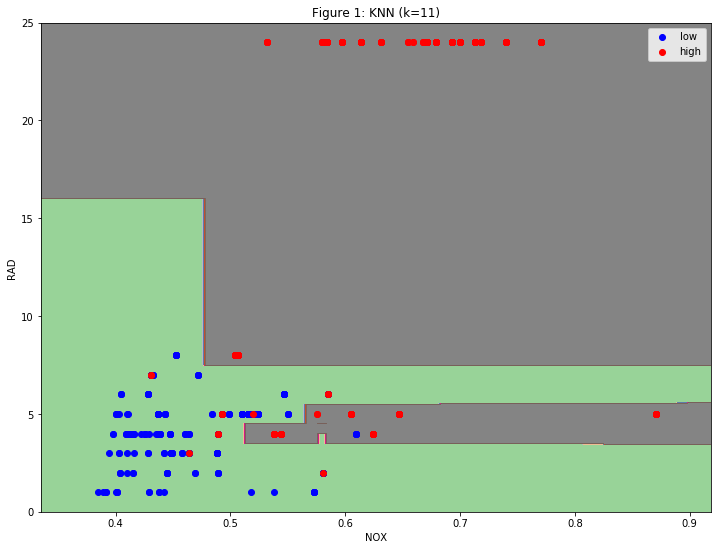

In [14]:
X = df.loc[:,subset_0]
X = X.to_numpy()    
#---min and max for the first feature---
x_min, x_max = X[:, 0].min() - 0.05, X[:, 0].max() + 0.05
#---min and max for the second feature---
y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1
#---step size in the mesh---
h = (x_max - x_min)/200
#---make predictions for each of the points in xx,yy---
xx, yy = np.meshgrid(np.arange(x_min, x_max, h),
                    np.arange(y_min, y_max, h))    
Z = cls[0].predict(np.c_[xx.ravel(), yy.ravel()])
Z = Z.reshape(xx.shape)
plt.figure(figsize=(12,9))
plt.contourf(xx, yy, Z, cmap=plt.cm.Accent, alpha=0.8)
#---plot the training points---
for color, i, target in zip(colors, [0, 1], ['low','high']):
    plt.scatter(X[y==i, 0], X[y==i, 1], color=color, label=target)
plt.xlabel(subset_0[0])
plt.ylabel(subset_0[1])
plt.title('Figure 1: KNN (k=%d)' %ks[0])
plt.legend(loc='best', shadow=False, scatterpoints=1)

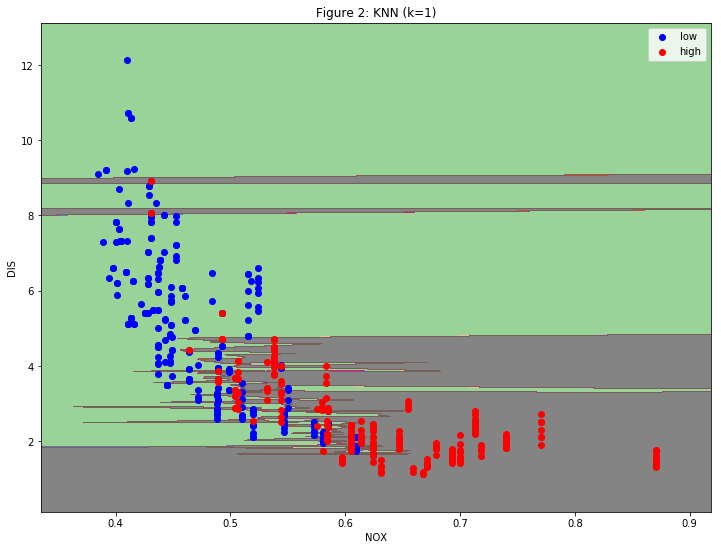

In [15]:
X = df.loc[:,subset_1]
X = X.to_numpy()    
#---min and max for the first feature---
x_min, x_max = X[:, 0].min() - 0.05, X[:, 0].max() + 0.05
#---min and max for the second feature---
y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1
#---step size in the mesh---
h = (x_max - x_min)/200
#---make predictions for each of the points in xx,yy---
xx, yy = np.meshgrid(np.arange(x_min, x_max, h),
                    np.arange(y_min, y_max, h))    
Z = cls[1].predict(np.c_[xx.ravel(), yy.ravel()])
Z = Z.reshape(xx.shape)
plt.figure(figsize=(12,9))
plt.contourf(xx, yy, Z, cmap=plt.cm.Accent, alpha=0.8)
#---plot the training points---
for color, i, target in zip(colors, [0, 1], ['low','high']):
    plt.scatter(X[y==i, 0], X[y==i, 1], color=color, label=target)
plt.xlabel(subset_1[0])
plt.ylabel(subset_1[1])
plt.title('Figure 2: KNN (k=%d)' %ks[1])
plt.legend(loc='best', shadow=False, scatterpoints=1)

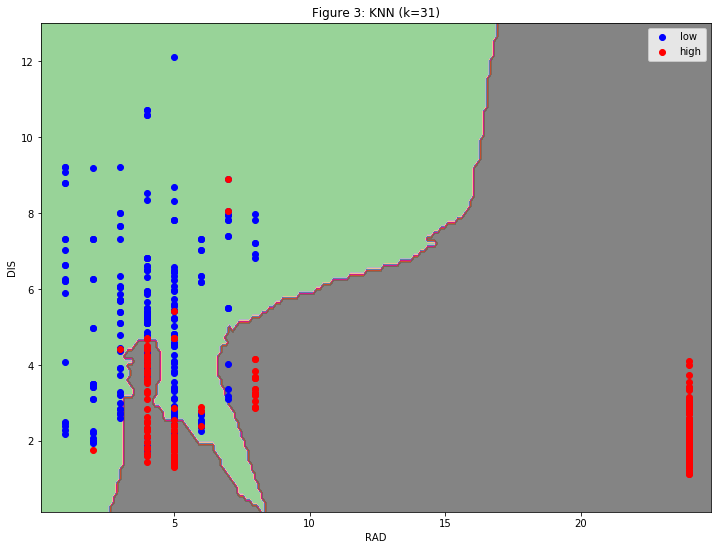

In [16]:
X = df.loc[:,subset_2]
X = X.to_numpy()    
#---min and max for the first feature---
x_min, x_max = X[:, 0].min() - 0.9, X[:, 0].max() + 0.9
#---min and max for the second feature---
y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1
#---step size in the mesh---
h = (x_max - x_min)/200
#---make predictions for each of the points in xx,yy---
xx, yy = np.meshgrid(np.arange(x_min, x_max, h),
                    np.arange(y_min, y_max, h))    
Z = cls[2].predict(np.c_[xx.ravel(), yy.ravel()])
Z = Z.reshape(xx.shape)
plt.figure(figsize=(12,9))
plt.contourf(xx, yy, Z, cmap=plt.cm.Accent, alpha=0.8)
#---plot the training points---
for color, i, target in zip(colors, [0, 1], ['low','high']):
    plt.scatter(X[y==i, 0], X[y==i, 1], color=color, label=target)
plt.xlabel(subset_2[0])
plt.ylabel(subset_2[1])
plt.title('Figure 3: KNN (k=%d)' %ks[2])
plt.legend(loc='best', shadow=False, scatterpoints=1)

### 4.- Item (d)

From all the plots made in the last section, figure 1 has fewer misclassifications. Moreover, figure 2 evidences an overfitting, it makes sense because parameter **K** equals one is used for this classifier. Finally, as it was reported, classifier of figure 1 had the highest score and the one of figure 2 had a low score.